# Perceiving only neighbor position

In this notebook, the agents perceive the other agent's relative position but *not* its speed. This is a much simpler task than the opposite (perceive speed but not position) that we explore in :doc:`Distributed-Speed-SAC`.

In [1]:
from navground import core, sim
from navground.learning import ControlActionConfig, DefaultObservationConfig
from navground.learning.parallel_env import make_vec_from_penv
from navground.learning.examples.pad import get_env, marker, neighbor
from stable_baselines3.common.vec_env import VecMonitor

name = "DistributedPosition"
action = ControlActionConfig(use_acceleration_action=True, max_acceleration=1, fix_orientation=True)
observation = DefaultObservationConfig(flat=False, include_velocity=True, include_target_direction=False)
sensors = [marker(), neighbor(max_speed=0)]
train_env = get_env(action=action, observation=observation, 
                    sensors=sensors, start_in_opposite_sides=False)
train_venv = VecMonitor(make_vec_from_penv(train_env, num_envs=4))
test_env = get_env(action=action, observation=observation, 
                   sensors=sensors, start_in_opposite_sides=True)
test_venv = VecMonitor(make_vec_from_penv(test_env, num_envs=4))

We removed the neighbor position from the observation:

In [2]:
train_venv.observation_space

Dict('neighbor/position': Box(-10.0, 10.0, (1, 1), float32), 'pad/x': Box(-1.0, 1.0, (1,), float32), 'ego_velocity': Box(-0.14, 0.14, (1,), float32))

## Training

You can skip training and instead load the last trained policy by changing the flag below.

In [3]:
from navground.learning.utils.jupyter import skip_if, run_if

training = True

In [4]:
%%skip_if $training

import pathlib, os
from stable_baselines3 import SAC

log = max(pathlib.Path(f'logs/{name}/SAC').glob('*'), key=os.path.getmtime)

In [5]:
%%run_if $training

from datetime import datetime as dt
from stable_baselines3 import SAC
from stable_baselines3.common.logger import configure
from navground.learning.utils.sb3 import callbacks
from navground.learning.scenarios.pad import render_kwargs

model = SAC("MultiInputPolicy", train_venv, verbose=0)
stamp = dt.now().strftime("%Y%m%d_%H%M%S")
log = f"logs/{name}/SAC/{stamp}"
model.set_logger(configure(log, ["csv", "tensorboard"]))
cbs = callbacks(venv=test_venv, best_model_save_path=log, 
                eval_freq=500, export_to_onnx=True, **render_kwargs())
log

'logs/DistributedPosition/SAC/20250521_131201'

In [6]:
%%run_if $training

model.learn(total_timesteps=100_000, reset_num_timesteps=False, log_interval=10, callback=cbs)
model.num_timesteps

  0%|          | 0/100000 [00:00<?, ?it/s]

100000

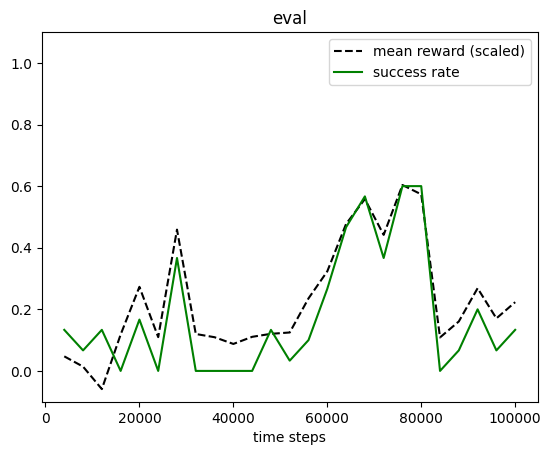

In [7]:
from navground.learning.utils.sb3 import plot_eval_logs

plot_eval_logs(log, reward_low=-200, reward_high=0, success=True)

## Evaluation

In [8]:
from stable_baselines3.common.evaluation import evaluate_policy

best_model = SAC.load(f'{log}/best_model')
evaluate_policy(best_model.policy, test_venv, n_eval_episodes=30)

(-141.27864, 74.90241)

In [9]:
from navground.learning.evaluation.video import display_episode_video

display_episode_video(test_env, policy=best_model.policy, factor=4, seed=1, **render_kwargs())

In [10]:
from navground.learning.evaluation.video import record_episode_video

record_episode_video(test_env, policy=best_model.policy, 
                     path=f'../videos/{name}.mp4', seed=1, **render_kwargs())

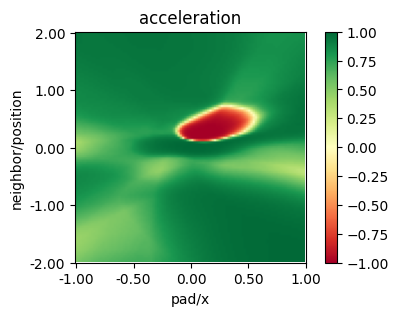

In [11]:
from navground.learning.utils.plot import plot_policy

plot_policy(best_model.policy, 
            variable={'pad/x': (-1, 1), 'neighbor/position': (-2, 2)},
            fix={'ego_velocity': 0.07},
            actions={0: 'acceleration'}, width=5, height=3)

As we see, the agent learns to brake when it is near to the pad and to the other agent.